In [17]:
import solver
import network
import data
import numpy as np
import matplotlib.pyplot as plt
import copy

In [18]:
dataloader_nonidentical = data.iid.TransientRLTask(batch_size = 1, seq_len = [4,4,4,4], input_dim = 1000, identical = False)

In [19]:
def initialize_nets():
    D = 1000

    teacher1 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True )
    teacher2 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True  )
    teacher3 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True  )
    teacher4 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True )

    teacher_c = network.ContextTeacher(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign', normalize = False )

    student1 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True  )
    student2 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True )
    student3 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True  )
    student4 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True  )

    student_c = network.ContextStudent(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign', normalize = False )
    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4], teacher_c, student_c

In [23]:
teachers, students, teacher_cs, student_cs = initialize_nets()
ode_students = copy.deepcopy(students)
ode_teachers = copy.deepcopy(teachers)
VS = student_cs.layers[0].weight.data.numpy().copy()[0]
VT = teacher_cs.layers[0].weight.data.numpy().copy()[0]
ode = solver.ode.HierarchicalODESolver(VS = VS, VT = VT, students = ode_students, teachers = ode_teachers, 
                                       lr_ws = [1,1], lr_v = 1, seq_length = 4,  N=1000, )
base_solver = solver.TwoPhaseContextSolver(teachers = teachers, \
                                          students = students, context_teacher = teacher_cs, 
                                          context_student = student_cs, dataloaders = [dataloader_nonidentical,
                                                                                      dataloader_nonidentical,
                                                                                     dataloader_nonidentical], logdir = None, identical = False)
base_solver.lr1_w=1
base_solver.lr2_w = 1
base_solver.lr2_v = 1
base_solver.update_frequency = 1
base_solver.phase1 = False
base_solver.phase2 = True
base_solver._setup_history()
base_solver.dw = []
base_solver.dv = []

In [35]:
import joblib as jl

In [36]:
hist=jl.load('hrl_ode_logs/baseline/20230717161241/ode.jl')

In [39]:
len(hist['phase2']['VS'])

10

In [27]:
base_solver.metric()
for i in range(50000):
    current_VS= base_solver.context_student.layers[0].weight.data.numpy().copy()[0]
    current_R = base_solver.R.copy()
    current_Q = base_solver.Q.copy()
    base_solver._phase2_step(dataloader_nonidentical.get_batch()['x'])
    if i%100 == 0:
        base_solver.metric()
    updated_VS=base_solver.context_student.layers[0].weight.data.numpy().copy()[0]
    updated_R = base_solver.R.copy()
    updated_Q = base_solver.Q.copy()
    if i % 100 == 0:
        ode_update = True
    else:
        ode_update = False
    ode._step2(ode_update,  None, None, None)

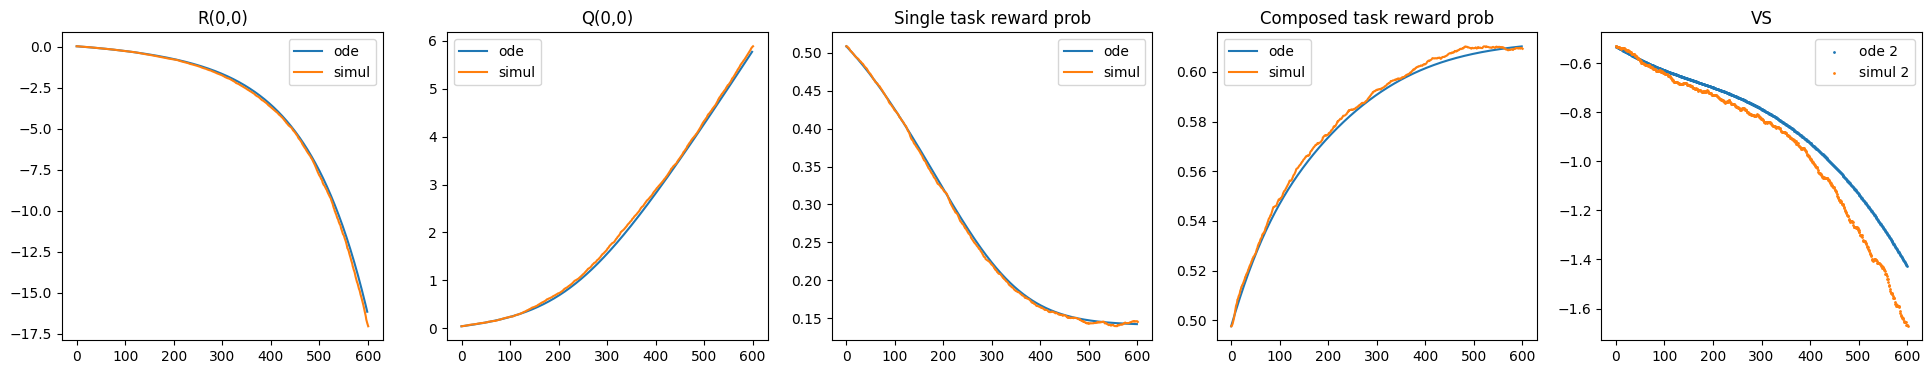

In [28]:
_ode = True
_simul = True
i,j = [0,0]
fig2 = plt.figure(figsize=(24, 4))
ax1 = plt.subplot(151)
if _ode:
    R=[k[i,j] for k in ode.history['phase2']['R']]
    ax1.plot(R, label = 'ode')
if _simul:
    RR=[k[i,j] for k in base_solver.history['phase2']['R']]

    ax1.plot(RR, label = 'simul')
    
ax1.set_title('R(0,0)')
plt.legend()
ax2 = plt.subplot(152)

if _ode:
    Q=[k[i,j] for k in ode.history['phase2']['Q']]
    #Qk=[k[i,j] for k in ode.history['Qk']]
    #Ql=[k[i,j] for k in ode.history['Ql']]
    #Qkl=[k[i,j] for k in ode.history['Qkl']]
    
    ax2.plot(np.log(Q), label = 'ode')
    #ax2.plot(Qk, label = 'ode k')
    #ax2.plot(Ql, label = 'ode l ')
    #ax2.plot(Qkl, label = 'ode kl')
if _simul:
    QQ=[k[i,j] for k in base_solver.history['phase2']['Q']]
    ax2.plot(np.log(QQ), label = 'simul')
ax2.set_title('Q(0,0)')
plt.legend()

ax3 = plt.subplot(153)
if _ode:
    P=ode.history['phase2']['P']
    ax3.plot([p[0] for p in P], label = 'ode')
if _simul:
    PP=base_solver.history['phase2']['P']
    ax3.plot([p[0] for p in PP], label = 'simul')
ax3.set_title('Single task reward prob')
plt.legend()

ax4 = plt.subplot(154)
if _ode:
    P=ode.history['phase2']['P_tilde']
    ax4.plot(P, label = 'ode')
if _simul:
    PP=base_solver.history['phase2']['P_tilde']
    ax4.plot(PP, label = 'simul')
ax4.set_title('Composed task reward prob')
plt.legend()

ax5 = plt.subplot(155)
i=2
if _ode:
    dv=[k[i] for k in ode.history['phase2']['VS']]
    ax5.scatter(np.arange(len(dv)), dv, label = f'ode {i}', s=1)
if _simul:
    dvv=[k[i] for k in base_solver.history['phase2']['VS']]
    ax5.scatter(np.arange(len(dvv)), dvv, label = f'simul {i}', s=1)


ax5.set_title('VS')
plt.legend()

In [63]:
len(P)

400

In [23]:
R

[-0.0015196718297702892,
 -0.0015149161379558597,
 -0.001510160338493173,
 -0.00150540443137826,
 -0.0015006484166071522,
 -0.00149589229417588,
 -0.0014911360640804743,
 -0.0014863797263169653,
 -0.0014816232808813833,
 -0.0014768667277697582,
 -0.0014721100669781199,
 -0.001467353298502498,
 -0.0014625964223389215,
 -0.00145783943848342,
 -0.0014530823469320222,
 -0.001448325147680757,
 -0.001443567840725653,
 -0.0014388104260627383,
 -0.0014340529036880412,
 -0.0014292952735975896,
 -0.0014245312206618904,
 -0.0014197670597088062,
 -0.0014150027907343476,
 -0.0014102384137345248,
 -0.0014054739287053478,
 -0.0014007093356428264,
 -0.0013959446345429701,
 -0.0013911798254017884,
 -0.0013864149082152904,
 -0.001381649882979485,
 -0.0013768847496903813,
 -0.0013721195083439873,
 -0.0013673488052874713,
 -0.001362577993873807,
 -0.001357807074098985,
 -0.0013530360459589952,
 -0.0013482649094498278,
 -0.0013434936645674723,
 -0.0013387223113079186,
 -0.0013339508496671556,
 -0.001329179